In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Datasets

## Dataset

In [1]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/nnytj2v3n5-1.zip

In [3]:
!unzip nnytj2v3n5-1.zip

Archive:  nnytj2v3n5-1.zip
   creating: Segmented Medicinal Leaf Images/
   creating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllus (Jackfruit)/
  inflating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllus (Jackfruit)/AH-S-038.jpg  
  inflating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllus (Jackfruit)/AH-S-056.jpg  
  inflating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllus (Jackfruit)/AH-S-047.jpg  
  inflating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllus (Jackfruit)/AH-S-029.jpg  
  inflating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllus (Jackfruit)/AH-S-003.jpg  
  inflating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllus (Jackfruit)/AH-S-021.jpg  
  inflating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllus (Jackfruit)/AH-S-012.jpg  
  inflating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllus (Jackfruit)/AH-S-030.jpg  
  inflating: Segmented Medicinal Leaf Images/Artocarpus Heterophyllu

## Backgrounds

In [6]:
! cp /content/drive/MyDrive/Capstone\ asset/backgrounds.zip . 

In [7]:
!unzip backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
  inflating: backgrounds/13.jpg      
  inflating: backgrounds/7.jpg       
  inflating: backgrounds/10.jpg      
  inflating: backgrounds/1.jpg       
  inflating: backgrounds/4.jpg       
  inflating: backgrounds/5.jpg       
  inflating: backgrounds/3.jpg       
  inflating: backgrounds/2.jpg       
  inflating: backgrounds/12.jpg      
  inflating: backgrounds/9.jpg       
  inflating: backgrounds/11.jpg      
  inflating: backgrounds/6.jpg       


# Load Data

In [8]:
import tensorflow as tf
import numpy as np
import cv2
import os

In [9]:
def get_background_list(dir):
  ls = []
  for filename in os.listdir(dir):
    ls.append(os.path.join(dir, filename))
  return ls

In [10]:
def generate_object_boundingbox(img):
    '''
    generate object bounding box using Canny
    :params img: image containing the object
    :return list: (x_left, y_top, x_right, y_bottom)
    '''
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray = cv2.blur(img_gray, (3,3))
    img_canny =  cv2.Canny(img_gray, 100, 100*2)

    contours, _ = cv2.findContours(img_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # generate bounding boxes
    bounding_boxes = []
    for contour in contours:
        polygon = cv2.approxPolyDP(contour, 3, True)
        bounding_boxes.append(cv2.boundingRect(polygon))
    
    # find the outer bounding box
    x_r, y_b = 0, 0
    x_l, y_t, _ = img.shape
    for box in bounding_boxes:
        if box[0] < x_l:
            x_l = box[0]
        if box[1] < y_t:
            y_t = box[1]
        if box[0] + box[2] > x_r:
            x_r = box[0] + box[2]
        if box[1] + box[3] > y_b:
            y_b = box[1] + box[3]
    return x_l, y_t, x_r, y_b

def get_background_mask(img):
  mask = np.zeros(img.shape[:2], np.uint8)
  bgdmodel = np.zeros((1, 65), np.float64)
  fgdmodel = np.zeros((1, 65), np.float64)

  rect = generate_object_boundingbox(img)
  # print(rect)

  cv2.grabCut(img, mask, rect, bgdmodel, fgdmodel, 5, cv2.GC_INIT_WITH_RECT)

  mask2 = np.where((mask==2)|(mask==0), 1, 0).astype('uint8')

  return mask2

In [11]:
src_dir = 'Segmented Medicinal Leaf Images'
mask_dir = 'dataset_leaves1_mask'
background_list = get_background_list('backgrounds')

def get_mask_by_threshold(img):
  img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  ret, mask = cv2.threshold(img_gray, 240, 255, 0)
  return mask/255

def modify_background(img_float):
  img = img_float.astype(np.uint8)
  background = cv2.imread(np.random.choice(background_list))
  h, w, _ = img.shape
  background = cv2.resize(background, (w,h))
  background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
  # mask = get_background_mask(img)
  mask = get_mask_by_threshold(img)

  fg = img*(1-mask)[:,:,np.newaxis]
  bg = background*mask[:,:,np.newaxis]

  new_img = (fg+bg).astype(np.float32)
  return new_img

In [12]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=modify_background,
    rotation_range=90,
    width_shift_range=.05,
    height_shift_range=.05,
    shear_range=.05,
    zoom_range=[1, 2],
    channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1/255.0,
    validation_split=0.2,
)

In [13]:
dir = 'Segmented Medicinal Leaf Images'
training_gen = training_datagen.flow_from_directory(
                    dir,
                    target_size=(224,224),
                    batch_size=32,
                    class_mode='categorical',
                    shuffle=True,
                    subset='training'
                )
validation_gen = training_datagen.flow_from_directory(
                    dir,
                    target_size=(224,224),
                    batch_size=32,
                    class_mode='categorical',
                    subset='validation'  
                )

Found 1479 images belonging to 30 classes.
Found 356 images belonging to 30 classes.


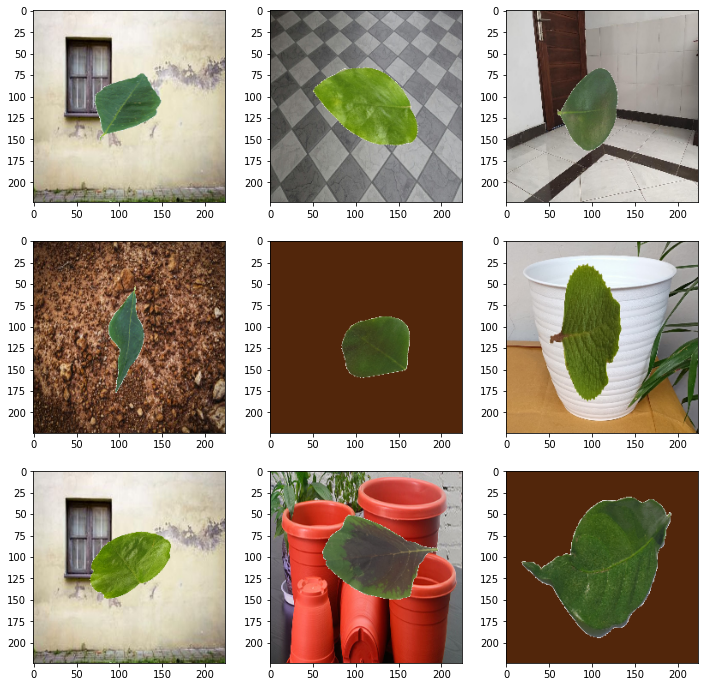

In [14]:
import matplotlib.pyplot as plt
n_row, n_col = (3,3)
_, axs = plt.subplots(n_row, n_col, figsize=(12,12))
axs = axs.flatten()
batch = next(validation_gen)
# print(batch)
for data, ax in zip(batch[0][:9], axs):
  ax.imshow(data)
  

plt.show()

In [15]:
finetuning = True
feature_extractor = tf.keras.applications.MobileNetV2(
                    input_shape=(224,224,3),
                    include_top=False,
                    weights='imagenet',
)

for layer in feature_extractor.layers:
    layer.trainable=finetuning

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_extractor.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
inputs = feature_extractor.inputs
x = feature_extractor(inputs)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(training_gen.num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
# Custom model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(224,224,3)),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dropout(.3),
                             tf.keras.layers.Dense(1280, activation='relu'),
                             tf.keras.layers.Dense(training_gen.num_classes, activation='softmax')

])

In [24]:
model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']   
    )

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        1

In [26]:
from datetime import datetime
EPOCHS = 50

tb = tf.keras.callbacks.TensorBoard(log_dir='logs/custom/content/drive/MyDrive/Capstone asset/Results/logs/custom20210601_061150{}'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
history = model.fit(training_gen,
                    epochs=EPOCHS,
                    validation_data=validation_gen,
                    callbacks=[tb, reduce_lr])

Epoch 1/50
47/47 [==============================] - 79s 2s/step - loss: 3.4049 - accuracy: 0.0636 - val_loss: 3.3642 - val_accuracy: 0.0618
Epoch 2/50
47/47 [==============================] - 77s 2s/step - loss: 3.3326 - accuracy: 0.0832 - val_loss: 3.1733 - val_accuracy: 0.1236
Epoch 3/50
47/47 [==============================] - 78s 2s/step - loss: 2.9507 - accuracy: 0.1339 - val_loss: 2.7775 - val_accuracy: 0.1742
Epoch 4/50
47/47 [==============================] - 75s 2s/step - loss: 2.6548 - accuracy: 0.1995 - val_loss: 2.4894 - val_accuracy: 0.2247
Epoch 5/50
47/47 [==============================] - 75s 2s/step - loss: 2.4593 - accuracy: 0.2326 - val_loss: 2.3182 - val_accuracy: 0.3146
Epoch 6/50
47/47 [==============================] - 76s 2s/step - loss: 2.3191 - accuracy: 0.2819 - val_loss: 2.1877 - val_accuracy: 0.3202
Epoch 7/50
47/47 [==============================] - 78s 2s/step - loss: 2.1517 - accuracy: 0.3185 - val_loss: 2.0904 - val_accuracy: 0.3399
Epoch 8/50
47/47 [==

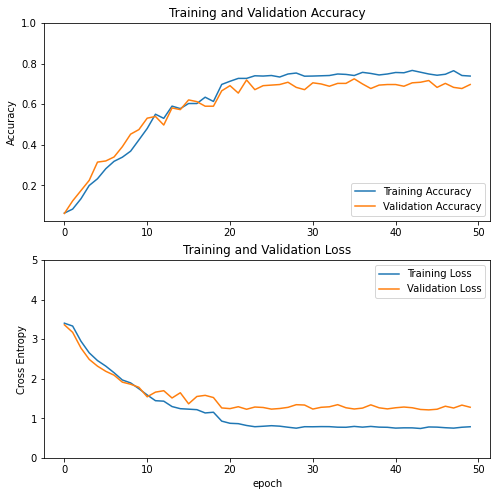

In [27]:

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Capstone\ asset/Results/logs/custom20210601_061150

In [ ]:
! cp -r logs/* /content/drive/MyDrive/Capstone\ asset/Results/logs

# Save the Model

In [28]:
target_dir = '/content/drive/MyDrive/Capstone asset/models/leaves1'
try:
  os.mkdir(target_dir)
except:
  pass

model.save(target_dir + '/custom_bgmodify3')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone asset/models/leaves1/custom_bgmodify3/assets


In [29]:
with open(target_dir+'/labels2.txt', 'w') as f:
  f.write('\n'.join(training_gen.class_indices.keys()))

In [ ]:
print(training_gen.class_indices.keys())

dict_keys(['Alpinia Galanga (Lengkuas)', 'Amaranthus Viridis (Bayam Ramping)', 'Artocarpus Heterophyllus (Nangka)', 'Azadirachta Indica (Mimba)', 'Basella Alba (Bayam Malabar)', 'Brassica Juncea (Sawi India)', 'Carissa Carandas (Buah Samarinda)', 'Citrus Limon (Lemon)', 'Ficus Auriculata (Roxburgh Ara)', 'Ficus Religiosa (Kalpataru)', 'Hibiscus Rosa-sinensis (Bunga Sepatu)', 'Jasminum (Bunga Melati)', 'Mangifera Indica (Mangga)', 'Mentha (Daun Mint)', 'Moringa Oleifera (Daun Kelor)', 'Muntingia Calabura (Buah Kersen - Seri)', 'Murraya Koenigii (Salam Koja - Daun Kari)', 'Nerium Oleander (Bunga Jepun - Oleander)', 'Nyctanthes Arbor-tristis (Srigading)', 'Ocimum Tenuiflorum (Ruku-Ruku)', 'Piper Betle (Sirih)', 'Plectranthus Amboinicus (Sukan - Daun Jintan)', 'Pongamia Pinnata (Malapari)', 'Psidium Guajava (Jambu Biji)', 'Punica Granatum (Delima)', 'Santalum Album (Cendana)', 'Syzygium Cumini (Jamblang)', 'Syzygium Jambos (Jambu Mawar)', 'Tabernaemontana Divaricata (Mondokaki - Bunga Wari

In [ ]:
tf.__version__

'2.5.0'

# Evaluating


In [ ]:
predictions = []
ys = []
i=0
for images, labels in validation_gen:
  if i>10: break
  i+=1
  y = np.argmax(labels, axis=1)
  predicts = model.predict(images)
  pred = np.argmax(predicts, axis=1)
  ys = ys + list(y)
  predictions = predictions + list(pred)
  print(pred, y)  

In [31]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(ys, predictions)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

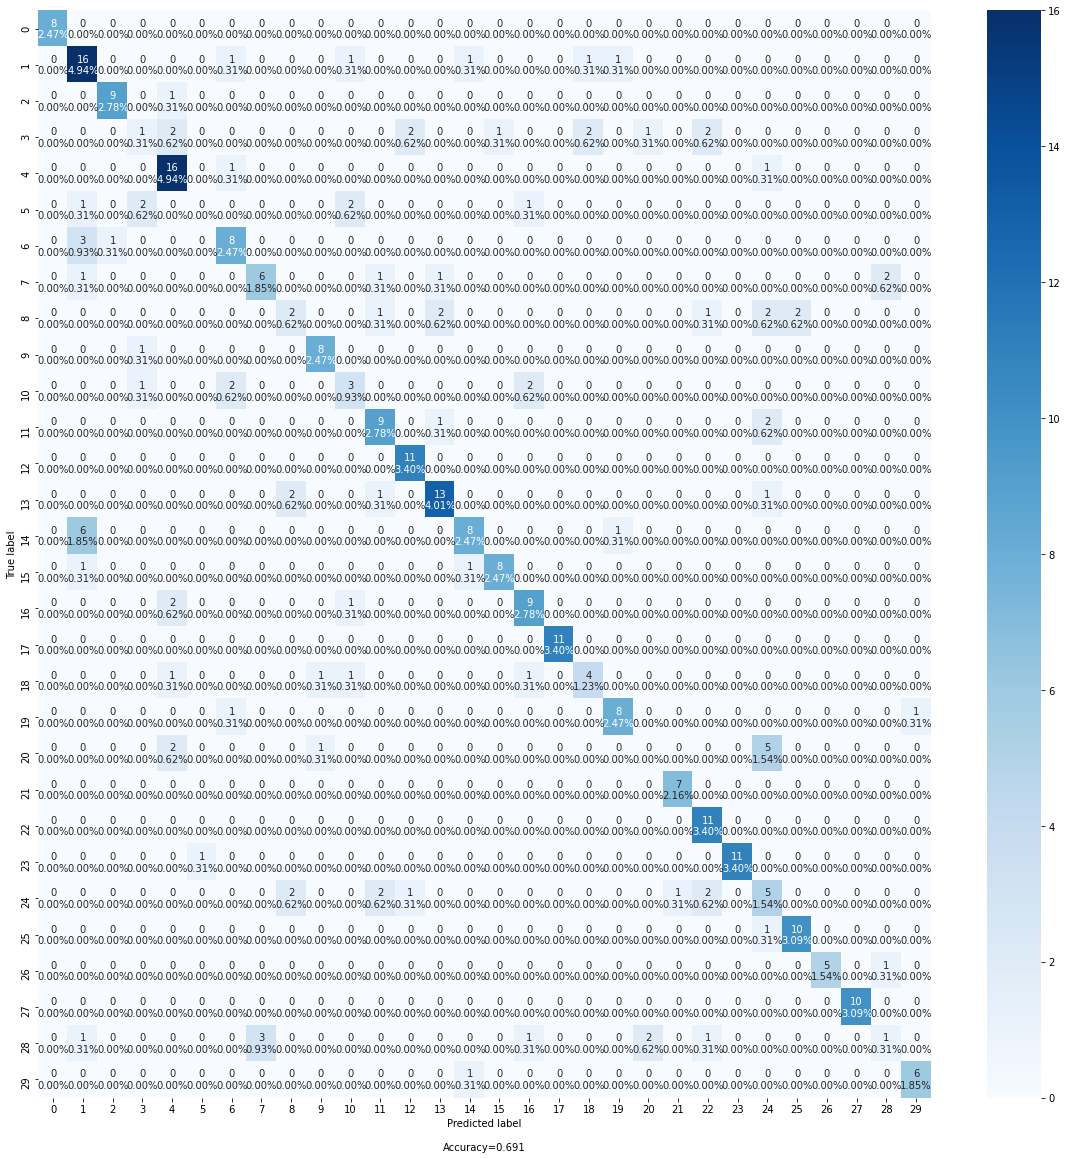

In [33]:
make_confusion_matrix(cf_matrix, 
                      figsize=(20,20))

# Testing

In [63]:
from google.colab import files
uploaded = files.upload()

Saving images (1).jpeg to images (1).jpeg


In [64]:
key = None
for k in uploaded.keys():
  key = k
  break
f = uploaded[key]
print(f)

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x13\x13\x12\x15\x12\x13\x13\x16\x15\x15\x17\x16\x17\x18\x15\x18\x17\x17\x18\x16\x15\x18\x18\x15\x18\x17\x17\x15\x18\x18\x18\x18\x1d( \x18\x1a%\x1d\x15\x15!1!%)+...\x17\x1f383,7(-.+\x01\n\n\n\x0e\r\x0e\x1a\x10\x10\x1a-% %-------------------------------------------------+\xff\xc0\x00\x11\x08\x01\x03\x00\xc2\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x00\x02\x05\x06\x01\x07\xff\xc4\x00=\x10\x00\x01\x03\x02\x04\x03\x05\x07\x02\x04\x06\x02\x03\x00\x00\x00\x01\x00\x02\x11\x03!\x04\x121A\x05Qa"q\x81\x91\xa1\x06\x132\xb1\xc1\xd1\xf0B\xe1\x14#Rb\x15r\x92\xa2\xb2\xf1S\xc2\x073\x82\xff\xc4\x00\x19\x01\x00\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x00\x04\x05\xff\xc4\x00#\x11\x00\x02\x02\x03\x01\x00\x03\x00\x02\x03\x00\x00\x00\x00\x00\x00\x00\x01\x02\x11\x03!1\x12\x13AQ"2\x04q\xa1\xff

In [65]:
from PIL import Image
import io

img = Image.open(io.BytesIO(f))
img = np.array(img)

In [66]:
def preprocess(img):
  img = cv2.resize(img, (224,224))
  img = np.asarray(img, dtype=np.float32) / 255.0
  img = np.expand_dims(img, axis=0)
  return img

In [67]:
img = preprocess(img)
pred = model.predict(img)[0]


92% Basella Alba (Basale)


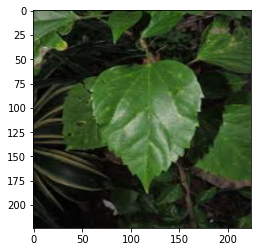

In [68]:
y = np.argmax(pred)
score = pred[y]
plt.imshow(img[0])

print("{}% {}".format(int(score*100), list(training_gen.class_indices.keys())[y]))

In [56]:
y

16

In [ ]:
training_gen.class_indices

{'Alpinia Galanga (Lengkuas)': 0,
 'Amaranthus Viridis (Bayam Ramping)': 1,
 'Artocarpus Heterophyllus (Nangka)': 2,
 'Azadirachta Indica (Mimba)': 3,
 'Basella Alba (Bayam Malabar)': 4,
 'Brassica Juncea (Sawi India)': 5,
 'Carissa Carandas (Buah Samarinda)': 6,
 'Citrus Limon (Lemon)': 7,
 'Ficus Auriculata (Roxburgh Ara)': 8,
 'Ficus Religiosa (Kalpataru)': 9,
 'Hibiscus Rosa-sinensis (Bunga Sepatu)': 10,
 'Jasminum (Bunga Melati)': 11,
 'Mangifera Indica (Mangga)': 12,
 'Mentha (Daun Mint)': 13,
 'Moringa Oleifera (Daun Kelor)': 14,
 'Muntingia Calabura (Buah Kersen - Seri)': 15,
 'Murraya Koenigii (Salam Koja - Daun Kari)': 16,
 'Nerium Oleander (Bunga Jepun - Oleander)': 17,
 'Nyctanthes Arbor-tristis (Srigading)': 18,
 'Ocimum Tenuiflorum (Ruku-Ruku)': 19,
 'Piper Betle (Sirih)': 20,
 'Plectranthus Amboinicus (Sukan - Daun Jintan)': 21,
 'Pongamia Pinnata (Malapari)': 22,
 'Psidium Guajava (Jambu Biji)': 23,
 'Punica Granatum (Delima)': 24,
 'Santalum Album (Cendana)': 25,
 'Syz

# Resize the Dataset

In [ ]:
%cd /content/drive/MyDrive/Capstone\ asset/Leaves\ Images

/content/drive/MyDrive/Capstone asset/Leaves Images


In [ ]:
dir = 'Leaves1'

In [ ]:
import os
import cv2
from tqdm import tqdm
import time

target_dir = '/content/dataset_leaves1'
try:
  os.mkdir(target_dir)
except:
  pass

for cls in os.listdir(dir):
  cls_dir = os.path.join(dir, cls)
  target_cls_dir = os.path.join(target_dir, cls)
  try:
    os.mkdir(target_cls_dir)
  except:
    pass
  files = os.listdir(cls_dir)
  for filename in tqdm(files, desc=cls):
    src = os.path.join(cls_dir, filename)
    dst = os.path.join(target_cls_dir, filename)

    img = cv2.imread(src)

    h,w,_ = img.shape
    h = h//2
    w = w//2

    img = cv2.resize(img, (w,h))

    cv2.imwrite(dst, img)

Plectranthus Amboinicus (Sukan - Daun Jintan): 100%|██████████| 48/48 [00:10<00:00,  4.47it/s]
Tabernaemontana Divaricata (Mondokaki - Bunga Wari): 100%|██████████| 56/56 [00:12<00:00,  4.41it/s]
Santalum Album (Cendana): 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


In [ ]:
%cd /content

/content


In [ ]:
!zip -r dataset_small.zip dataset_leaves1

  adding: dataset_leaves1/ (stored 0%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/ (stored 0%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/MC-S-049.jpg (deflated 6%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/MC-S-018.jpg (deflated 5%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/MC-S-029.jpg (deflated 5%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/MC-S-028.jpg (deflated 5%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/MC-S-023.jpg (deflated 5%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/MC-S-045.jpg (deflated 5%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/MC-S-047.jpg (deflated 6%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/MC-S-052.jpg (deflated 6%)
  adding: dataset_leaves1/Muntingia Calabura (Buah Kersen - Seri)/MC-S-019.jpg (deflated 4%)
  adding: dataset_leaves1/Muntingia Calabura 

In [ ]:
!cp dataset_small.zip /content/drive/MyDrive/Capstone\ asset/dataset_leaves1.zip

In [ ]:
!rm -rf /content/dataset_leaves1/.ipynb_checkpoints/

# Save Weights

In [ ]:
!cp drive/MyDrive/Capstone\ asset/models/leaves1/resnet50_bgmodify.h5 .

In [ ]:
import tensorflow as tf

src_path = 'resnet50_bgmodify.h5'

model = tf.keras.models.load_model(src_path)


In [ ]:
import numpy as np

input = np.random.rand(1,224,224,3)
pred = model.predict(input)
print(np.argmax(pred))

6


In [ ]:
%cd drive/MyDrive/Capstone\ asset/models/leaves1

/content/drive/MyDrive/Capstone asset/models/leaves1


In [ ]:
dst_path = 'resnet50_bgmodify'
model.save(dst_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: resnet50_bgmodify/assets


In [ ]:
!zip -r custom_bgmodify.zip custom_bgmodify

  adding: custom_bgmodify/ (stored 0%)
  adding: custom_bgmodify/variables/ (stored 0%)
  adding: custom_bgmodify/variables/variables.data-00000-of-00001 (deflated 33%)
  adding: custom_bgmodify/variables/variables.index (deflated 67%)
  adding: custom_bgmodify/assets/ (stored 0%)
  adding: custom_bgmodify/saved_model.pb (deflated 88%)
  adding: custom_bgmodify/keras_metadata.pb (deflated 92%)
